## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import math
from itertools import chain
import sklearn.model_selection as skl
from random import sample
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet121
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
68764,00016972_000.png,Atelectasis,0,16972,43,F,PA,2606,2565,0.143000,0.143000,NaN,/data/images_008/images/00016972_000.png
85720,00021144_001.png,Infiltration,1,21144,44,M,PA,2020,2021,0.194314,0.194314,NaN,/data/images_010/images/00021144_001.png
40576,00010544_000.png,Pneumonia,0,10544,33,F,AP,2500,2048,0.168000,0.168000,NaN,/data/images_005/images/00010544_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

selected_disease_labels = ['Atelectasis', 'Edema', 'Effusion', 'Infiltration', 'Pneumonia']

for c_label in selected_disease_labels:
    if len(c_label) > 1:
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0 )

In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df['Finding Labels'].map(lambda finding: "pneumonia" if "Pneumonia" in finding else "non_pneumonia")

all_xray_df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Edema,Effusion,Infiltration,Pneumonia,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png,0,0,0,0,0,non_pneumonia
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png,0,0,0,0,0,non_pneumonia
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png,0,0,1,0,0,non_pneumonia
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000002_000.png,0,0,0,0,0,non_pneumonia
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/data/images_001/images/00000003_000.png,0,0,0,0,0,non_pneumonia


## Create your training and testing data:

In [5]:
def create_splits(d):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    #Remove outliers cases above 100
    d_mod = d[d['Patient Age'] <=100]
    train_data, val_data = skl.train_test_split(d_mod, 
                                   test_size = 0.2, 
                                   stratify = d_mod['pneumonia_class'])
    
    p_inds  = train_data[train_data['Pneumonia'] == 1].index.tolist()
    np_inds = train_data[train_data['Pneumonia'] == 0].index.tolist()
    
    np_sample = sample(np_inds, len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]
    
    p_inds = val_data[val_data['Pneumonia'] == 1].index.tolist()
    np_inds = val_data[val_data['Pneumonia'] == 0].index.tolist()

    np_sample = sample(np_inds, 4*len(p_inds))
    val_data = val_data.loc[p_inds + np_sample]
    
    return train_data, val_data

train_data, val_data = create_splits(all_xray_df)

Text(0.5, 1.0, 'Patient Gender Distribution on Train Data')

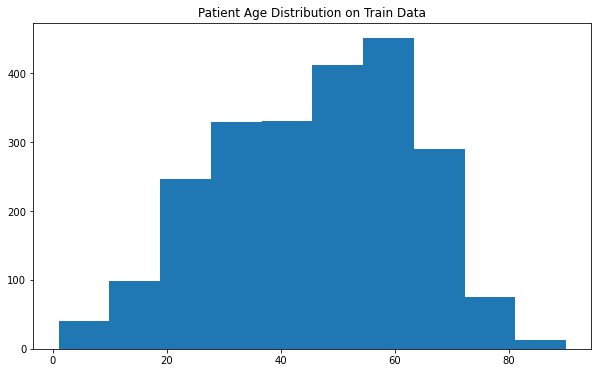

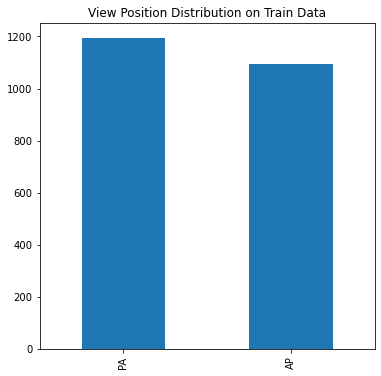

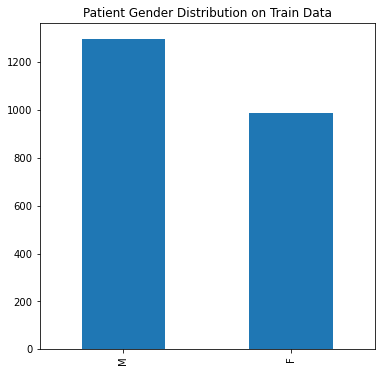

In [6]:
#Age
plt.figure(figsize=(10,6))
plt.hist(train_data['Patient Age'])
plt.title('Patient Age Distribution on Train Data')


#Patient Position
plt.figure(figsize=(6,6))
train_data['View Position'].value_counts().plot(kind='bar')
plt.title('View Position Distribution on Train Data')


#Patient Gender
plt.figure(figsize=(6,6))
train_data['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Patient Gender Distribution on Train Data')

Text(0.5, 1.0, 'Patient Gender Distribution on Validation Data')

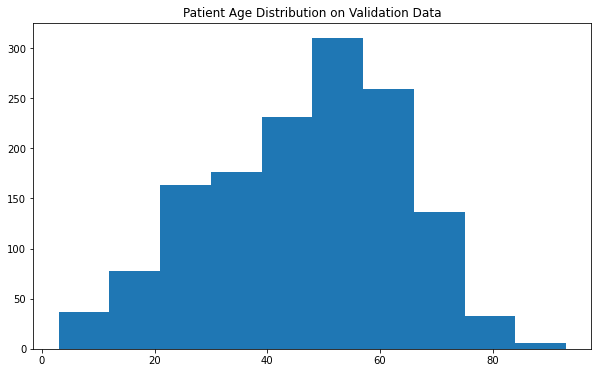

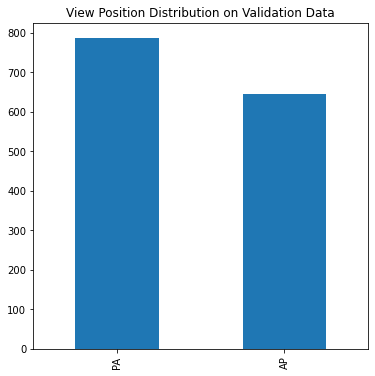

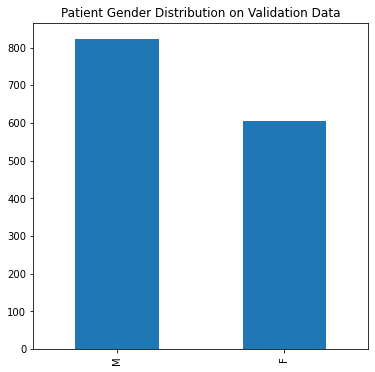

In [7]:
#Age
plt.figure(figsize=(10,6))
plt.hist(val_data['Patient Age'])
plt.title('Patient Age Distribution on Validation Data')


#Patient Position
plt.figure(figsize=(6,6))
val_data['View Position'].value_counts().plot(kind='bar')
plt.title('View Position Distribution on Validation Data')


#Patient Gender
plt.figure(figsize=(6,6))
val_data['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Patient Gender Distribution on Validation Data')

Both the training and validation data exhibit strong alignment with patterns observed in the original dataset, making this an excellent representation for effective model training.

In [8]:
print(train_data['Pneumonia'].sum()/len(train_data))
print(val_data['Pneumonia'].sum()/len(val_data))

0.5
0.2


# Now we can begin our model-building & training

#### For normalization we will compute mean and std deviation on train_data  and use these values for train, val and also later during inference 

In [10]:


def compute_mean_std(train_data, img_size=(224, 224), batch_size=128):
    # Use only rescaling, no augmentation
    simple_idg = ImageDataGenerator(rescale=1./255.0)
    gen = simple_idg.flow_from_dataframe(dataframe=train_data, directory=None, x_col='path', y_col='pneumonia_class',
                                         class_mode='binary', target_size=img_size, batch_size=batch_size, shuffle=False)
    
    pixel_sum = 0.
    pixel_squared_sum = 0.
    num_batches = 0
    num_pixels = 0
    
    for i in range(len(gen)):
        batch = gen[i][0]  # gen[i] = (images, labels)
        pixel_sum += np.sum(batch, axis=(0, 1, 2))  # sum across height, width, batch
        pixel_squared_sum += np.sum(np.square(batch), axis=(0, 1, 2))
        num_pixels += np.prod(batch.shape[:-1])  # total pixels (excluding channel dimension)
        num_batches += 1
        if (i + 1) * batch_size >= len(gen.filenames):
            break  # Avoid extra batch with different shape
    
    mean = pixel_sum / num_pixels
    std = np.sqrt(pixel_squared_sum / num_pixels - np.square(mean))
    
    return mean, std

mean, std = compute_mean_std(train_data)
print(f'Mean : {mean}, Standard Deviation {std}')


Found 2288 validated image filenames belonging to 2 classes.
Mean : [0.48660422 0.48660422 0.48660422], Standard Deviation [0.25033459 0.25033459 0.25033459]


#### Add normalize funtion, data augmentation

In [11]:

def normalize_fn(img):
    return (img - mean) / std

def my_image_augmentation():
    
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              preprocessing_function=normalize_fn,
                              horizontal_flip = True, 
                              vertical_flip = False, ## now i'm adding vertical flip
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=30, ## I'm also increasing the rotation_range
                              shear_range = 0.1,
                              zoom_range=0.15)
    
    return my_idg

IMG_SIZE = (224, 224)

def make_train_gen(train_data, IMG_SIZE):
    my_train_idg = my_image_augmentation()
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data, directory=None, x_col = 'path', y_col = 'pneumonia_class',
                                         class_mode = 'binary', target_size = IMG_SIZE, batch_size = 128)

    return train_gen


def make_val_gen(val_data, IMG_SIZE):
    val_idg = ImageDataGenerator(rescale=1. / 255.0, 
                                 preprocessing_function=normalize_fn,)
    val_gen = val_idg.flow_from_dataframe(dataframe=val_data, directory=None, x_col = 'path', y_col = 'pneumonia_class',
                                         class_mode = 'binary', target_size = IMG_SIZE, batch_size = 128, shuffle=False)
    
    return val_gen

val_gen  = make_val_gen(val_data, IMG_SIZE )
train_gen = make_train_gen(train_data, IMG_SIZE)

Found 1430 validated image filenames belonging to 2 classes.
Found 2288 validated image filenames belonging to 2 classes.


In [12]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

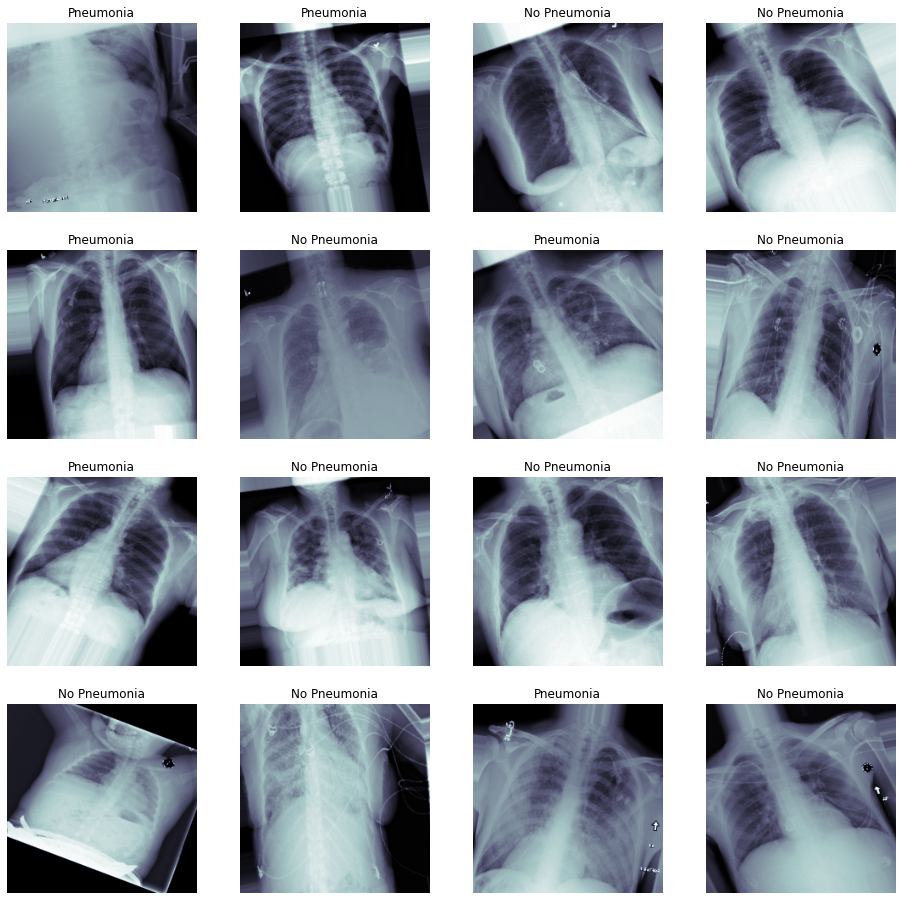

In [13]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Model 1: VGG16 with dense layers added

In [14]:
def load_pretrained_vgg_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    model.summary()
    
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

    return vgg_model

vgg_model = load_pretrained_vgg_model()
count = 0
for layer in vgg_model.layers[0:17]:
    print(f'{count} : {layer.name}')
    layer.trainable = False
    count += 1

553467904/553467096 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [15]:
def build_my_model1():
   
    my_model = Sequential()
    my_model.add(vgg_model)
    
    my_model.add(GlobalAveragePooling2D())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(128, activation='relu'))
        
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.25))


    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model

my_model1 = build_my_model1()
my_model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 14,780,481
Trainable params: 2,425,601
Non-trainable params: 12,354,880
_________________________________________________________________


In [16]:
# Callbacks
weight_path = "{}_my_model.best.hdf5".format('pneumonia_detection')
patience = 15
checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only=True)

early = EarlyStopping(monitor='val_loss', 
                      mode='min', 
                      patience=patience)

# Decay learning rate when val accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,        # reduce LR by half
                              patience=patience, 
                              verbose=1,
                              mode='min',
                              min_lr=1e-6)

callbacks_list = [checkpoint, early, reduce_lr]


### Start training! 

In [17]:
## train your model

## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
my_model1.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = my_model1.fit_generator(train_gen, 
                          validation_data = val_gen, 
                          epochs = 25, 
                          callbacks = callbacks_list)

Epoch 1/25
18/18 [==============================] - 111s 6s/step - loss: 0.7020 - binary_accuracy: 0.5210 - val_loss: 0.7824 - val_binary_accuracy: 0.4231

Epoch 00001: val_loss improved from inf to 0.78243, saving model to pneumonia_detection_my_model.best.hdf5
Epoch 2/25
18/18 [==============================] - 87s 5s/step - loss: 0.6751 - binary_accuracy: 0.5712 - val_loss: 0.6694 - val_binary_accuracy: 0.6350

Epoch 00002: val_loss improved from 0.78243 to 0.66938, saving model to pneumonia_detection_my_model.best.hdf5
Epoch 3/25
18/18 [==============================] - 90s 5s/step - loss: 0.6632 - binary_accuracy: 0.5979 - val_loss: 0.7027 - val_binary_accuracy: 0.6119

Epoch 00003: val_loss did not improve from 0.66938
Epoch 4/25
18/18 [==============================] - 92s 5s/step - loss: 0.6548 - binary_accuracy: 0.6215 - val_loss: 0.6461 - val_binary_accuracy: 0.6636

Epoch 00004: val_loss improved from 0.66938 to 0.64610, saving model to pneumonia_detection_my_model.best.hdf5

##### After training for some time, lets look at the performance of your model by plotting some performance statistics:

In [18]:
my_model1.load_weights(weight_path)
pred_Y = my_model1.predict(val_gen, verbose = True)


12/12 [==============================] - 28s 2s/step


In [19]:
def plot_auc(t_y, p_y):

    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall+ 1e-8)

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

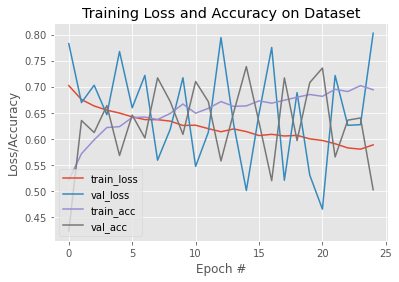

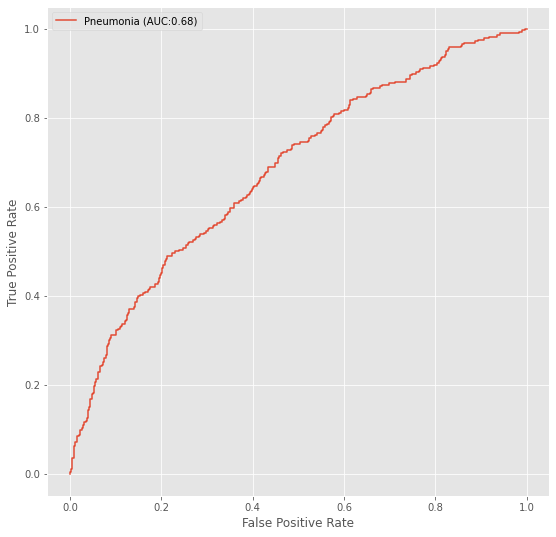

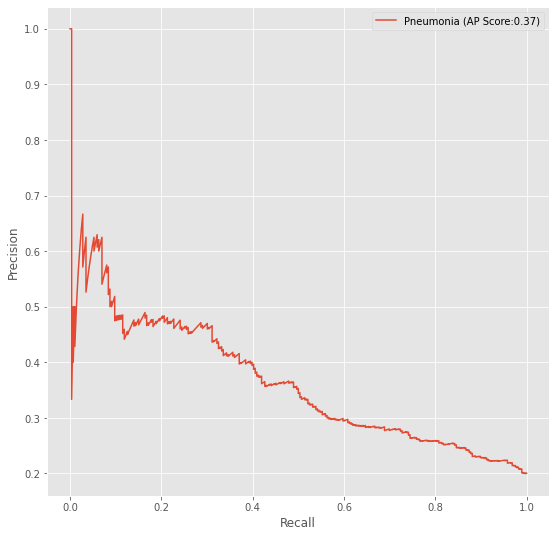

In [20]:
plot_history(history)
plot_auc(val_data['Pneumonia'], pred_Y)
plot_precision_recall_curve(val_data['Pneumonia'], pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

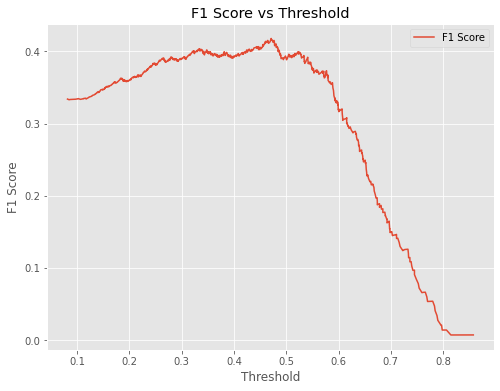

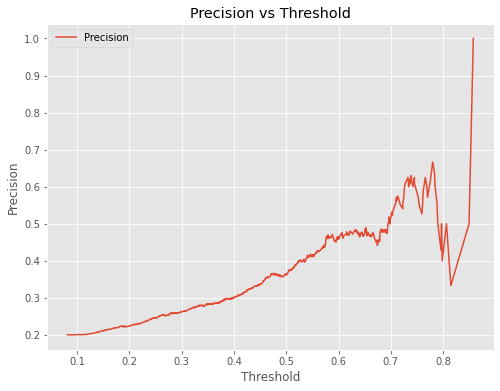

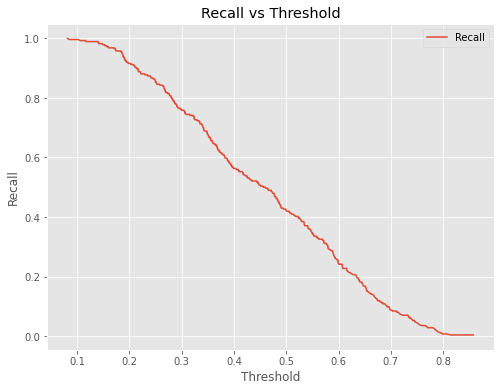

Best threshold: 0.4711, Best F1-score: 0.4179


In [21]:
precision, recall, thresholds = precision_recall_curve(val_data['Pneumonia'], pred_Y)

# Compute F1 scores
f1_scores = calc_f1(precision, recall)

# Plot F1-score vs threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.legend()
plt.show()

# Plot Precision vs threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Threshold')
plt.grid(True)
plt.legend()
plt.show()


# Plot Recall vs threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Threshold')
plt.grid(True)
plt.legend()
plt.show()

best_idx = np.nanargmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
print(f"Best threshold: {best_threshold:.4f}, Best F1-score: {best_f1:.4f}")

## Model 2: ResNet50 with dense layers added

In [22]:
def load_pretrained_resnet50_model():
    base_model = ResNet50(include_top=True, weights='imagenet')
    base_model.summary()

    # Get output from final conv layer
    transfer_layer = base_model.get_layer('conv5_block3_out')
    model = Model(inputs=base_model.input, outputs=transfer_layer.output)

    return model

resnet_model = load_pretrained_resnet50_model()
count = 0
for layer in resnet_model.layers[0:171]:
    print(f'{count} : {layer.name}')
    layer.trainable = False
    count += 1
    

102973440/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [23]:
def build_my_model_resnet():
   
    my_model = Sequential()
    my_model.add(resnet_model)
        
    my_model.add(GlobalAveragePooling2D())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the Resnet50 model has
    # recognized in the image.
    my_model.add(Dense(128, activation='relu'))
        
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.25))


    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model

my_model2 = build_my_model_resnet()
my_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 23,850,113
Trainable params: 1,317,121
Non-trainable params: 22,532,992
_________________________________________________________________


In [24]:
weight_path = "{}_my_model_resnet.best.hdf5".format('pneumonia_detection')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only=True)

early = EarlyStopping(monitor='val_loss', 
                      mode='min', 
                      patience=patience)

# Decay learning rate when val accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,        # reduce LR by half
                              patience=patience, 
                              verbose=1,
                              mode='min',
                              min_lr=1e-6)

callbacks_list = [checkpoint, early, reduce_lr]

my_model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = my_model2.fit_generator(train_gen, 
                          validation_data = val_gen, 
                          epochs = 25, 
                          callbacks = callbacks_list)

Epoch 1/25
18/18 [==============================] - 113s 6s/step - loss: 0.6937 - binary_accuracy: 0.5870 - val_loss: 0.6081 - val_binary_accuracy: 0.7923

Epoch 00001: val_loss improved from inf to 0.60805, saving model to pneumonia_detection_my_model_resnet.best.hdf5
Epoch 2/25
18/18 [==============================] - 91s 5s/step - loss: 0.6551 - binary_accuracy: 0.6106 - val_loss: 0.7745 - val_binary_accuracy: 0.2629

Epoch 00002: val_loss did not improve from 0.60805
Epoch 3/25
18/18 [==============================] - 94s 5s/step - loss: 0.6412 - binary_accuracy: 0.6455 - val_loss: 0.7989 - val_binary_accuracy: 0.2322

Epoch 00003: val_loss did not improve from 0.60805
Epoch 4/25
18/18 [==============================] - 94s 5s/step - loss: 0.6297 - binary_accuracy: 0.6508 - val_loss: 0.6967 - val_binary_accuracy: 0.4720

Epoch 00004: val_loss did not improve from 0.60805
Epoch 5/25
18/18 [==============================] - 95s 5s/step - loss: 0.6230 - binary_accuracy: 0.6512 - val_l

In [25]:
weight_path = "{}_my_model_resnet.best.hdf5".format('pneumonia_detection')

my_model2.load_weights(weight_path)
pred_Y = my_model2.predict(val_gen, verbose = True)


12/12 [==============================] - 32s 3s/step


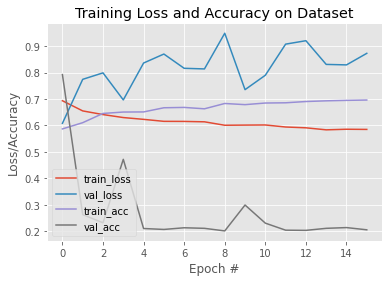

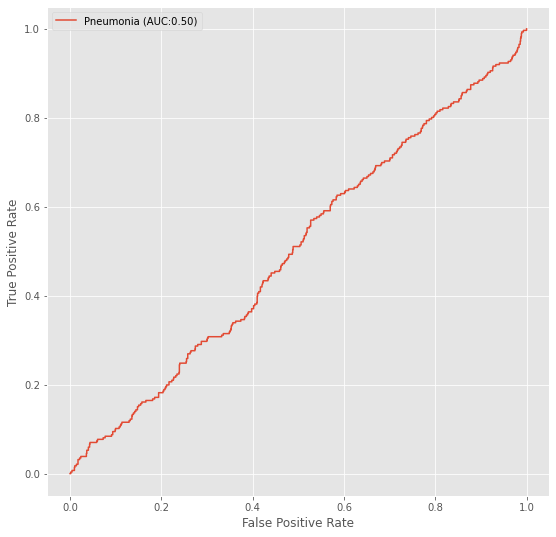

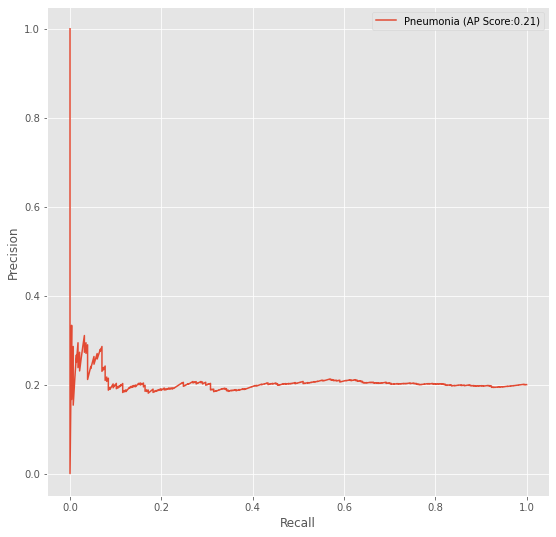

In [28]:
plot_history(history)
plot_auc(val_data['Pneumonia'], pred_Y)
plot_precision_recall_curve(val_data['Pneumonia'], pred_Y)

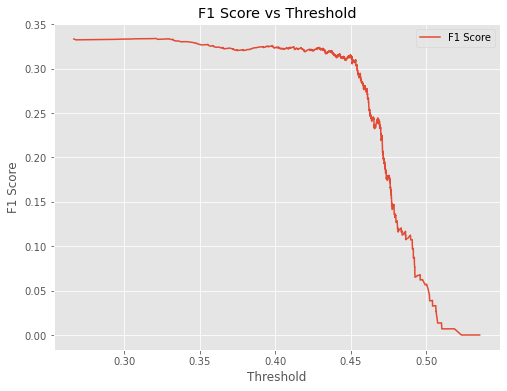

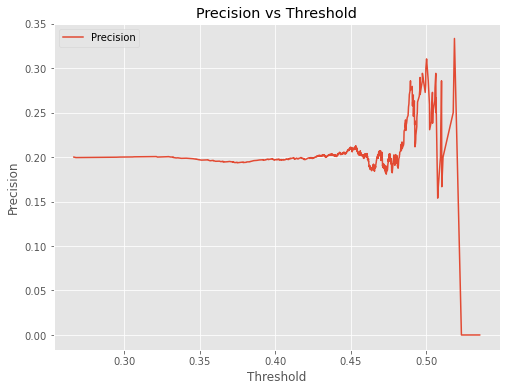

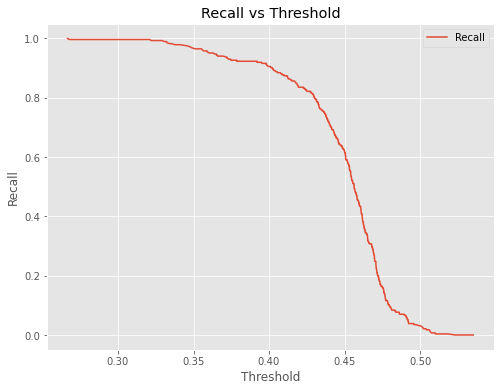

Best threshold: 0.3211, Best F1-score: 0.3339


In [29]:
precision, recall, thresholds = precision_recall_curve(val_data['Pneumonia'], pred_Y)

# Compute F1 scores
f1_scores = calc_f1(precision, recall)

# Plot F1-score vs threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.legend()
plt.show()

# Plot Precision vs threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Threshold')
plt.grid(True)
plt.legend()
plt.show()


# Plot Recall vs threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Threshold')
plt.grid(True)
plt.legend()
plt.show()

best_idx = np.nanargmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
print(f"Best threshold: {best_threshold:.4f}, Best F1-score: {best_f1:.4f}")

## Model 3: DenseNet121 with dense layers added

In [30]:
def load_pretrained_densenet():
    densenet_model = DenseNet121(include_top=True, weights='imagenet')
    
    densenet_model.summary()

     # Get output from final conv layer
    transfer_layer = densenet_model.get_layer('avg_pool')
    model = Model(inputs=densenet_model.input, outputs=transfer_layer.output)

    return model

densenet_model = load_pretrained_densenet()

count = 0
for layer in densenet_model.layers[0:420]:
    print(f'{count} : {layer.name}')
    layer.trainable = False
    count += 1



33193984/33188688 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________

In [31]:
def build_my_model_densenet():
   
    my_model = Sequential()
    my_model.add(densenet_model)
    
    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the DenseNet model has
    # recognized in the image.
    my_model.add(Dense(128, activation='relu'))
        
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.25))


    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model

my_model3 = build_my_model_densenet()
my_model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 1024)              7037504   
_________________________________________________________________
dense_5 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 7,168,833
Trainable params: 297,473
Non-trainable params: 6,871,360
_________________________________________________________________


In [32]:
weight_path = "{}_my_model_densenet.best.hdf5".format('pneumonia_detection')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only=True)

early = EarlyStopping(monitor='val_loss', 
                      mode='min', 
                      patience=patience)

# Decay learning rate when val accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,        # reduce LR by half
                              patience=patience, 
                              verbose=1,
                              mode='min',
                              min_lr=1e-6)

callbacks_list = [checkpoint, early, reduce_lr]

my_model3.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = my_model3.fit_generator(train_gen, 
                          validation_data = val_gen, 
                          epochs = 25, 
                          callbacks = callbacks_list)

Epoch 1/25
18/18 [==============================] - 136s 8s/step - loss: 0.7389 - binary_accuracy: 0.5332 - val_loss: 0.7845 - val_binary_accuracy: 0.4762

Epoch 00001: val_loss improved from inf to 0.78454, saving model to pneumonia_detection_my_model_densenet.best.hdf5
Epoch 2/25
18/18 [==============================] - 92s 5s/step - loss: 0.7029 - binary_accuracy: 0.5704 - val_loss: 0.7192 - val_binary_accuracy: 0.5888

Epoch 00002: val_loss improved from 0.78454 to 0.71924, saving model to pneumonia_detection_my_model_densenet.best.hdf5
Epoch 3/25
18/18 [==============================] - 100s 6s/step - loss: 0.6822 - binary_accuracy: 0.5966 - val_loss: 0.6286 - val_binary_accuracy: 0.6853

Epoch 00003: val_loss improved from 0.71924 to 0.62857, saving model to pneumonia_detection_my_model_densenet.best.hdf5
Epoch 4/25
18/18 [==============================] - 101s 6s/step - loss: 0.6650 - binary_accuracy: 0.5988 - val_loss: 0.6328 - val_binary_accuracy: 0.6846

Epoch 00004: val_loss

In [33]:
weight_path = "{}_my_model_densenet.best.hdf5".format('pneumonia_detection')

my_model3.load_weights(weight_path)
pred_Y = my_model3.predict(val_gen, verbose = True)

12/12 [==============================] - 36s 3s/step


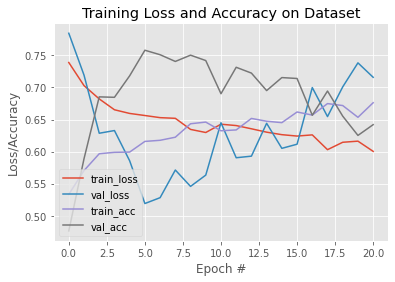

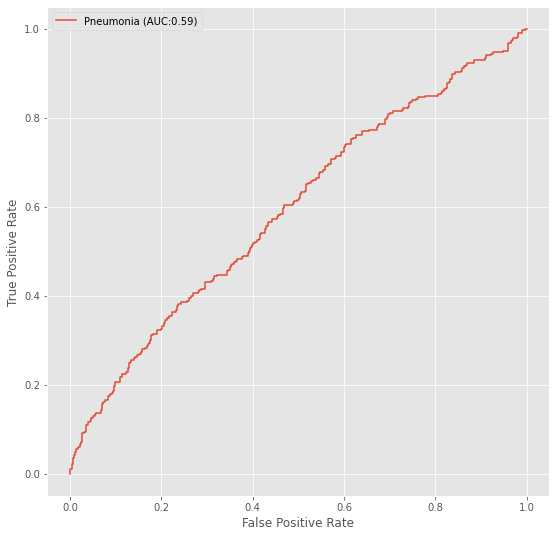

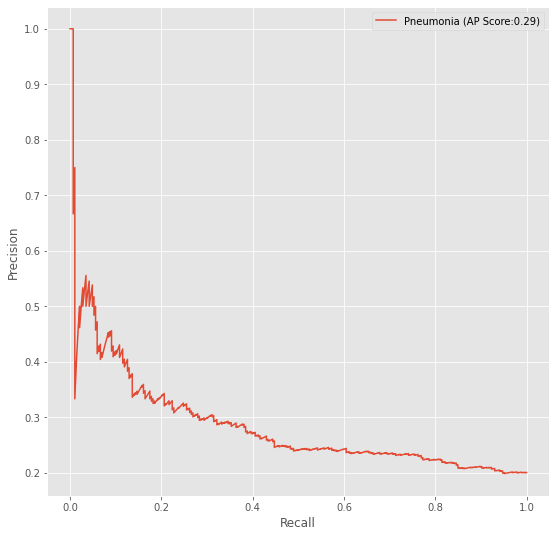

In [36]:
plot_history(history)
plot_auc(val_data['Pneumonia'], pred_Y)
plot_precision_recall_curve(val_data['Pneumonia'], pred_Y)

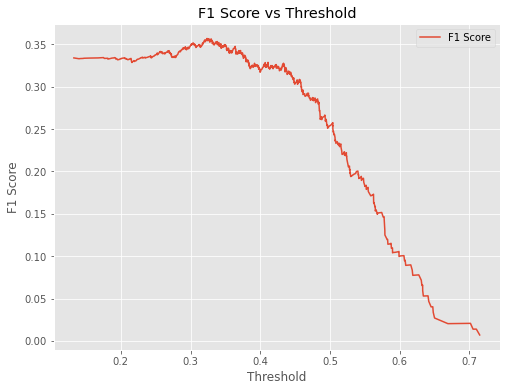

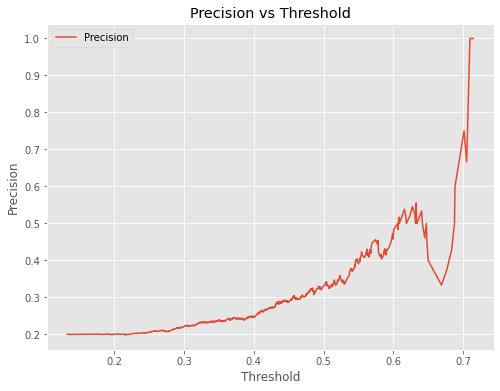

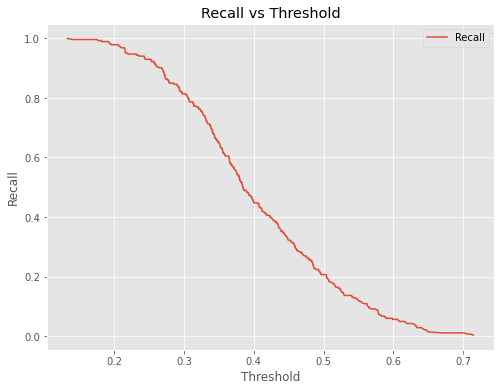

Best threshold: 0.3237, Best F1-score: 0.3571


In [37]:
precision, recall, thresholds = precision_recall_curve(val_data['Pneumonia'], pred_Y)

# Compute F1 scores
f1_scores = calc_f1(precision, recall)

# Plot F1-score vs threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.legend()
plt.show()

# Plot Precision vs threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Threshold')
plt.grid(True)
plt.legend()
plt.show()


# Plot Recall vs threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Threshold')
plt.grid(True)
plt.legend()
plt.show()

best_idx = np.nanargmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
print(f"Best threshold: {best_threshold:.4f}, Best F1-score: {best_f1:.4f}")

**Selection of Final Model**:

In this project, we evaluated three different architectures: VGG16, ResNet50, and DenseNet121. Based on the F1 score, precision, and recall metrics, VGG16 consistently outperformed the other models, achieving a maximum F1 score of 0.42. Therefore, we select Model 1 (based on VGG16) as our final model. In the following section, we will explore threshold selection for this model in greater detail.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 14,780,481
Trainable params: 2,425,601
Non-trainable params: 12,354,880
_________________________________________________________________
12/12 [==============================] - 29s 2s/step


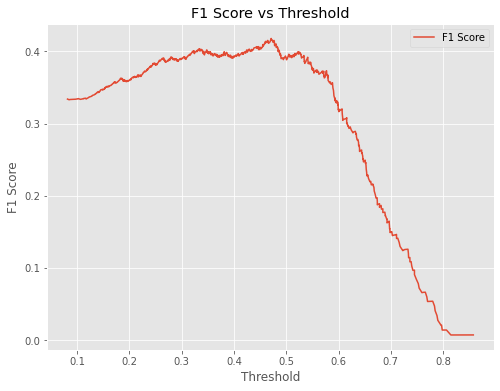

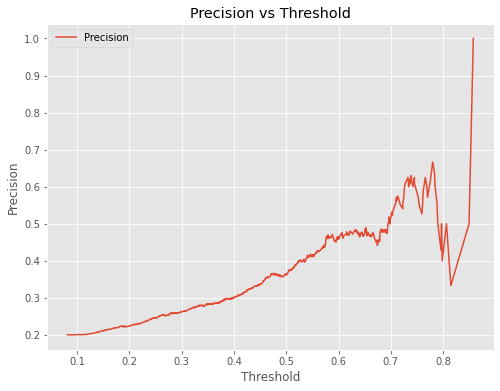

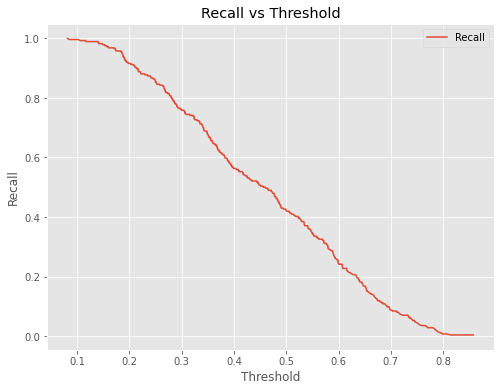

In [38]:
# Lets use model1 and rerun val data for final analysis
my_model1 = build_my_model1()
my_model1.summary()
weight_path = "{}_my_model.best.hdf5".format('pneumonia_detection')

my_model1.load_weights(weight_path)
pred_Y = my_model1.predict(val_gen, verbose = True)

precision, recall, thresholds = precision_recall_curve(val_data['Pneumonia'], pred_Y)

# Compute F1 scores
f1_scores = calc_f1(precision, recall)

# Plot F1-score vs threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.legend()
plt.show()

# Plot Precision vs threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Threshold')
plt.grid(True)
plt.legend()
plt.show()


# Plot Recall vs threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Threshold')
plt.grid(True)
plt.legend()
plt.show()

# Index of max F1
best_f1_idx = f1_scores.argmax()
best_f1_threshold = thresholds[best_f1_idx]

# Index of max precision
best_precision_idx = precision[:-1].argmax()  # drop last entry, not matched to threshold
best_precision_threshold = thresholds[best_precision_idx]

# Index of max recall
best_recall_idx = recall[:-1].argmax()        # drop last entry, not matched to threshold
best_recall_threshold = thresholds[best_recall_idx]

**Scenario 1**: Using max F1 score as final threshold

In [39]:
# Select best_f1_threshold as final threshold and lets evaluate accuracy over the val_data
threshold = round(best_f1_threshold, 2)

# Lets check precision and recall values
precision_at_max_f1 = round(precision[best_f1_idx], 2)
recall_at_max_f1 = round(recall[best_f1_idx], 2)
f1_score_at_max_f1 = round(f1_scores[best_f1_idx], 2)

print(f'Selected Threshold:{threshold:2f}, Precision:{precision_at_max_f1}, Recall:{recall_at_max_f1}, F1 Score:{f1_score_at_max_f1}\n')

val_data['Algorithm_Out'] = [1 if prob >= threshold else 0 for prob in pred_Y]

tn,fp,fn,tp =confusion_matrix(val_data['Pneumonia'], val_data['Algorithm_Out']).ravel()
print("Confusion Matrix \n")
print (tp, fp,"\n",fn,tn, "\n")

sens = round( tp/(tp+fn), 2)
spec = round( tn/(tn+fp), 2)

print(f'All Cases: Sensitivity:{sens}, Specificity:{spec} \n')
    
for i in ['Atelectasis','Effusion','Infiltration','Edema']:
    
    tn, fp, fn, tp = confusion_matrix(val_data[val_data[i]==1].Pneumonia.values,
                                                  val_data[val_data[i]==1].Algorithm_Out.values,labels=[0,1]).ravel()
    sens = round( tp/(tp+fn), 2)
    spec = round( tn/(tn+fp), 2)

    print(f'{i} Cases: Sensitivity:{sens}, Specificity:{spec} \n')


Selected Threshold:0.470000, Precision:0.36, Recall:0.49, F1 Score:0.42

Confusion Matrix 

140 247 
 146 897 

All Cases: Sensitivity:0.49, Specificity:0.78 

Atelectasis Cases: Sensitivity:0.35, Specificity:0.79 

Effusion Cases: Sensitivity:0.55, Specificity:0.58 

Infiltration Cases: Sensitivity:0.58, Specificity:0.61 

Edema Cases: Sensitivity:0.8, Specificity:0.39 



**Scenario 2**: Using max Precision score as final threshold

In [40]:
# Select best_precision_threshold as final threshold and lets evaluate accuracy over the val_data
threshold = round(best_precision_threshold, 2)

# Lets check precision and recall values
precision_at_max_precision = round(precision[best_precision_idx], 2)
recall_at_max_precision = round(recall[best_precision_idx], 2)
f1_score_at_max_precision = round(f1_scores[best_precision_idx], 2)

print(f'Selected Threshold:{threshold:2f}, Precision:{precision_at_max_precision}, Recall:{recall_at_max_precision}, F1 Score:{f1_score_at_max_precision}\n')

val_data['Algorithm_Out'] = [1 if prob >= threshold else 0 for prob in pred_Y]

tn,fp,fn,tp =confusion_matrix(val_data['Pneumonia'], val_data['Algorithm_Out'] ).ravel()
print("Confusion Matrix \n")
print (tp, fp,"\n",fn,tn, "\n")

sens = round( tp/(tp+fn), 2)
spec = round( tn/(tn+fp), 2)

print(f'All Cases: Sensitivity:{sens}, Specificity:{spec} \n')
    
for i in ['Atelectasis','Effusion','Infiltration','Edema']:
    
    tn, fp, fn, tp = confusion_matrix(val_data[val_data[i]==1].Pneumonia.values,
                                                  val_data[val_data[i]==1].Algorithm_Out.values,labels=[0,1]).ravel()
    sens = round( tp/(tp+fn), 2)
    spec = round( tn/(tn+fp), 2)

    print(f'{i} Cases: Sensitivity:{sens}, Specificity:{spec} \n')

Selected Threshold:0.860000, Precision:1.0, Recall:0.0, F1 Score:0.01

Confusion Matrix 

0 0 
 286 1144 

All Cases: Sensitivity:0.0, Specificity:1.0 

Atelectasis Cases: Sensitivity:0.0, Specificity:1.0 

Effusion Cases: Sensitivity:0.0, Specificity:1.0 

Infiltration Cases: Sensitivity:0.0, Specificity:1.0 

Edema Cases: Sensitivity:0.0, Specificity:1.0 



**Scenario 3**: Using max Recall score as final threshold

In [41]:
# Select best_recall_threshold as final threshold and lets evaluate accuracy over the val_data
threshold = round(best_recall_threshold, 2)

# Lets check precision and recall values
precision_at_max_recall = round(precision[best_recall_idx], 2)
recall_at_max_recall = round(recall[best_recall_idx], 2)
f1_score_at_max_recall = round(f1_scores[best_recall_idx], 2)

print(f'Selected Threshold:{threshold:2f}, Precision:{precision_at_max_recall}, Recall:{recall_at_max_recall}, F1 Score:{f1_score_at_max_recall}\n')

val_data['Algorithm_Out'] = [1 if prob >= threshold else 0 for prob in pred_Y]

tn,fp,fn,tp =confusion_matrix(val_data['Pneumonia'], val_data['Algorithm_Out']).ravel()
print("Confusion Matrix \n")
print (tp, fp,"\n",fn,tn, "\n")

sens = round( tp/(tp+fn), 2)
spec = round( tn/(tn+fp), 2)

print(f'All Cases: Sensitivity:{sens}, Specificity:{spec} \n')
    
for i in ['Atelectasis','Effusion','Infiltration','Edema']:
    
    tn, fp, fn, tp = confusion_matrix(val_data[val_data[i]==1].Pneumonia.values,
                                                  val_data[val_data[i]==1].Algorithm_Out.values,labels=[0,1]).ravel()
    sens = round( tp/(tp+fn), 2)
    spec = round( tn/(tn+fp), 2)

    print(f'{i} Cases: Sensitivity:{sens}, Specificity:{spec} \n')

Selected Threshold:0.080000, Precision:0.2, Recall:1.0, F1 Score:0.33

Confusion Matrix 

286 1141 
 0 3 

All Cases: Sensitivity:1.0, Specificity:0.0 

Atelectasis Cases: Sensitivity:1.0, Specificity:0.0 

Effusion Cases: Sensitivity:1.0, Specificity:0.01 

Infiltration Cases: Sensitivity:1.0, Specificity:0.0 

Edema Cases: Sensitivity:1.0, Specificity:0.0 



**Intepretation of all Scenarios and selecting best model**

1) Model 1: MAX F1 Score Model

This model strikes a balance between sensitivity (true positive rate) and specificity (true negative rate), aiming to maximize the F1 score—the harmonic mean of precision and recall. Its moderate sensitivity and specificity indicate reliable pneumonia detection without an excessive number of false alarms. Subgroup analysis reveals higher sensitivity for conditions like edema and effusion, though specificity declines in these cases.


2) Model 2: MAX Precision Score Model

This highly conservative model rarely predicts a positive case (very low sensitivity), but when it does, it's almost always correct—resulting in very high specificity and precision. However, it fails to detect the vast majority of true pneumonia cases.

3) Model 3 : MAX Recall (Sensitivity) Score Model

This model prioritizes capturing all pneumonia cases by labeling nearly every input as positive, maximizing sensitivity. However, it does so at the cost of specificity, misclassifying many non-pneumonia cases as positive.

**Best Model**

Model 1, with its balanced F1 score, is typically the best choice for clinical screening. It effectively reduces both missed diagnoses and false positives—crucial in pneumonia detection, where overlooking true cases can delay treatment, and false alarms can lead to unnecessary interventions

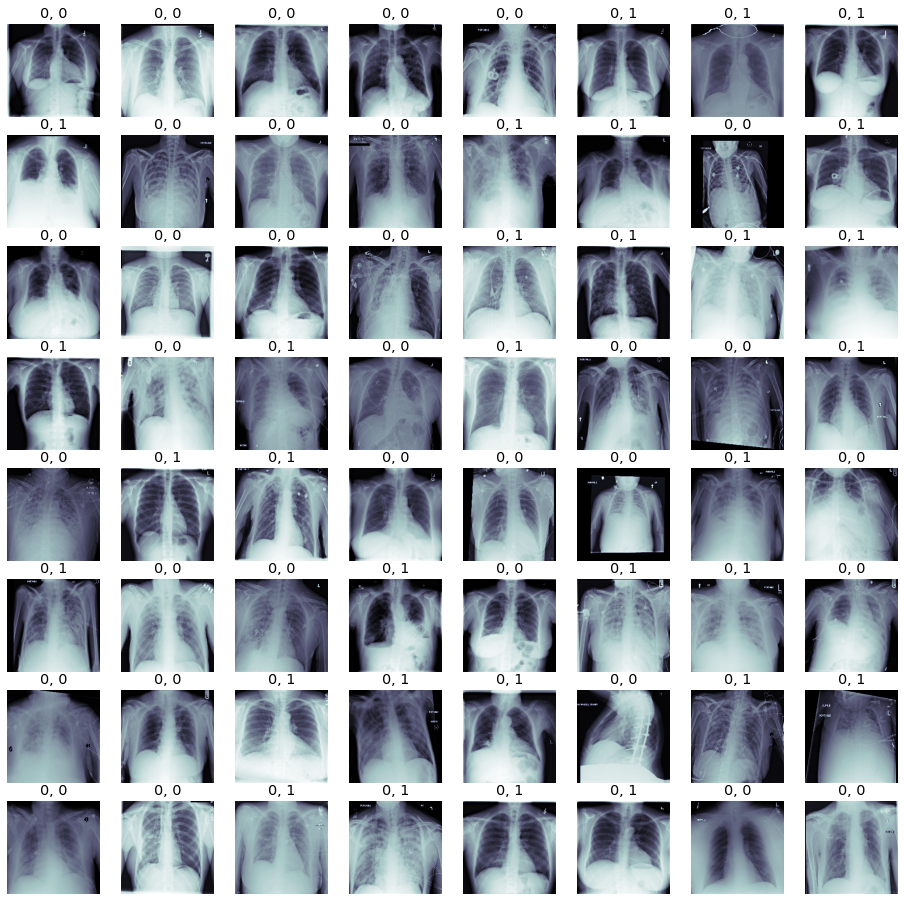

In [42]:
## Let's look at some examples of true vs. predicted with our best model: 
best_model_threshold = round(best_f1_threshold, 2)

v_x, v_y = next(val_gen)

fig, m_axs = plt.subplots(8, 8, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(v_x[0:64], pred_Y[0:64], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > best_model_threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > best_model_threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [43]:
## Just save model architecture to a .json:

model_json = my_model1.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)